In [1]:
import sys
!{sys.executable} -m pip install pillow matplotlib rasterio scikit-image scikit-learn

     |████████████████████████████████| 19.3 MB 1.1 MB/s 


In [2]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image # remove if needed 
from tqdm.notebook import tqdm_notebook
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

In [3]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


# Download the images and prepare them for the study

Create the list of pathways

In [4]:
pathway = ["08_December_2016","27_May_2017","06_December_2017","19_June_2018",
           "31_December_2018","26_June_2019","06_December_2019","23_June_2020",
           "11_Jan_2021","13_June_2021","07_December_2021"]

Download the 4 bands (RGB+NIR) and labels for each images

In [5]:
band2 = [rasterio.open("/content/drive/MyDrive/IPEO/" + path + "_images/band2.jpg").read(1) for path in pathway]
band3 = [rasterio.open("/content/drive/MyDrive/IPEO/" + path + "_images/band3.jpg").read(1) for path in pathway]
band4 = [rasterio.open("/content/drive/MyDrive/IPEO/" + path + "_images/band4.jpg").read(1) for path in pathway]
band11 = [rasterio.open("/content/drive/MyDrive/IPEO/" + path + "_images/band11.jpg").read(1) for path in pathway]
labels = [rasterio.open("/content/drive/MyDrive/IPEO/" + path + "_images/label.png").read(1) for path in pathway]

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [6]:
# Conversion of the bands and labels in numpy arrays
band2 = np.array(band2)
band3 = np.array(band3)
band4 = np.array(band4)
band11 = np.array(band11)
labels = np.array(labels)

In [7]:
# Convert from int8 to float32
band2 = band2.astype('float32')
band3 = band3.astype('float32')
band4 = band4.astype('float32')
band11 = band11.astype('float32')

Calculate the NDSI value

In [8]:
modifier_NDSI = 0.0001*np.ones(band2.shape) # Coefficient to avoid division by zero
NDSI = (band3-band11)/(band3+band11+modifier_NDSI)

Compute the matrix of features

In [9]:
X = np.array([band2,band3,band4,band11,NDSI])
X = np.transpose(X,(1,0,2,3)) # Transpose to the format image*band*width*height

In [10]:
#TODO remove before the end
print(X.shape)
import math
print(math.gcd(3024,2496))
print(2*2*2*2*3)
print(3024*2496/(16**2))

(11, 5, 3028, 2500)
48
48
29484.0


In [11]:
# Crop the image to have a size divisible by 48
X = X[:,:,:3024,:2496]
labels = labels[:,:3024,:2496]
labels.shape

(11, 3024, 2496)

Define some functions usefull to convert pixels to patches

In [12]:
def pixels_to_patches_labels(my_array, patch_size):
  n,a,b = my_array.shape[0],my_array.shape[1],my_array.shape[2]
  x = a//patch_size
  y = b//patch_size
  my_array_per_patch = np.zeros((n,x,y))
  for image in range(n):
    for k in range(x):
      for j in range(y):
        mean = my_array[image,k*patch_size:(k+1)*patch_size,j*patch_size:(j+1)*patch_size].mean()
        if mean>=0.5 :
          my_array_per_patch[image,k,j] = 1
  return my_array_per_patch   
#TODO remove after     
#labels_test = pixels_to_patches(labels, 48)
#print(labels[0,12:24,12:24])
#print(labels_test[0,1,1])

In [13]:
def compute_histogram(patch, bins, patch_size):
  hist = []
  patch_normalized = (patch-patch.min())/(patch.max()-patch.min())
  for k in range(bins):
    T = np.ones(patch_normalized.shape)
    hist.append(T[patch_normalized<=(k+1)/bins].sum())
  for k in range(bins-1,0,-1):
    hist[k] -= hist[k-1]  
  return np.array(hist)/patch_size**2

def compute_entropy(hist):
  return -np.nansum(hist*np.log(hist))

def compute_features_per_patch(patch, bins, patch_size):
  features = np.zeros((3+bins)) #mean, std, entropy and histogram with bins
  features[0] = patch.mean()
  features[1] = patch.std()
  hist = compute_histogram(patch,bins,patch_size)
  features[3:3+bins] = hist
  features[2] = compute_entropy(hist)
  return features

def pixels_to_patches_features(my_array, patch_size, bins=50):
  n,m,a,b = my_array.shape[0],my_array.shape[1],my_array.shape[2],my_array.shape[3]
  x = a//patch_size
  y = b//patch_size
  my_array_per_patch = np.zeros((n,(3+bins)*m,x,y))
  for image in tqdm_notebook(range(n)):
    for band in tqdm_notebook(range(m)):
      for k in range(x):
        for j in range(y):
          my_array_per_patch[image,band*(3+bins):(band+1)*(3+bins),k,j] = \
          compute_features_per_patch(my_array[image,band,k*patch_size:(k+1)*patch_size,j*patch_size:(j+1)*patch_size], bins, patch_size)
  return my_array_per_patch 

Make patches from original images and computes features and label per patch

In [14]:
X = pixels_to_patches_features(X, 12, bins=10) # 10 min to run it with bins=10, ~28 min with bins=50
X.shape

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

(11, 65, 252, 208)

In [33]:
labels = pixels_to_patches_labels(labels, 12)

# Split in train, validation and test sets

In [34]:
def flatten_X(X,k):
  X = X[k:k+1]
  X = np.transpose(X,(2,3,0,1))
  X = np.resize(X,(1*252*208,65)) # change in function of the bin 
  return X

def flatten_y(y,k):  
  y = y[k:k+1]
  y = y.flatten()
  return y 

In [35]:
X_flatten = [flatten_X(X,k) for k in range(11)]  
y_flatten = [flatten_y(labels,k) for k in range(11)]

#X_train = np.concatenate((X_flatten[0:2]+X_flatten[3:6]+X_flatten[7:10]),axis=0)
#X_test = np.concatenate((X_flatten[2:3]+X_flatten[6:7]+X_flatten[10:11]),axis=0)
#y_train = np.concatenate((y_flatten[0:2]+y_flatten[3:6]+y_flatten[7:10]),axis=0)
#y_test = np.concatenate((y_flatten[2:3]+y_flatten[6:7]+y_flatten[10:11]),axis=0)

X_train = np.concatenate((X_flatten[3:6]+X_flatten[7:10]),axis=0)
X_valid = np.concatenate(X_flatten[0:2],axis=0)
X_test = np.concatenate((X_flatten[2:3]+X_flatten[6:7]+X_flatten[10:11]),axis=0)
y_train = np.concatenate((y_flatten[3:6]+y_flatten[7:10]),axis=0)
y_valid = np.concatenate(y_flatten[0:2],axis=0)
y_test = np.concatenate((y_flatten[2:3]+y_flatten[6:7]+y_flatten[10:11]),axis=0)

print(X_train.shape,y_train.shape) 

#TODO remove
#X_test = X[2:3]
#X_test = np.transpose(X_test,(2,3,0,1))
#X_test=np.resize(X_test,(1*252*208,65))

#y_test = labels[2]
#y_test = y_test.flatten()

(314496, 65) (314496,)


# Create and train different models

Define function usefull for the study

In [36]:
def plot_confusion_matrix(conf_matrix):
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='x-large')
    
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Ground Truth', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()    

## Random Forest

Search for the best parameters

In [ ]:
n_estimators_values = [20, 50, 100, 200]
max_depth_values = [5, 10, 20, None]

for n in tqdm_notebook(n_estimators_values):
  for d in tqdm_notebook(max_depth_values):
    classifier = RandomForestClassifier(random_state = 10, n_estimators=n, max_depth=d)
    classifier.fit(X_train, y_train)
    prediction = classifier.predict(X_valid)
    accuracy = accuracy_score(y_valid, prediction)
    if d == None:
      print("Accuracy of %f with %d estimators without max depth" % (accuracy,n))
    else:  
      print("Accuracy of %f with %d estimators and max depth of %d" % (accuracy,n,d))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Accuracy of 0.936556 with 20 estimators and max depth of 5
Accuracy of 0.950836 with 20 estimators and max depth of 10
Accuracy of 0.950588 with 20 estimators and max depth of 20
Accuracy of 0.951227 with 20 estimators without max depth


  0%|          | 0/4 [00:00<?, ?it/s]

Accuracy of 0.936279 with 50 estimators and max depth of 5
Accuracy of 0.951341 with 50 estimators and max depth of 10
Accuracy of 0.951542 with 50 estimators and max depth of 20
Accuracy of 0.951675 with 50 estimators without max depth


  0%|          | 0/4 [00:00<?, ?it/s]

Accuracy of 0.936975 with 100 estimators and max depth of 5
Accuracy of 0.951542 with 100 estimators and max depth of 10
Accuracy of 0.951532 with 100 estimators and max depth of 20
Accuracy of 0.951894 with 100 estimators without max depth


  0%|          | 0/4 [00:00<?, ?it/s]

Accuracy of 0.936126 with 200 estimators and max depth of 5
Accuracy of 0.951713 with 200 estimators and max depth of 10
Accuracy of 0.951761 with 200 estimators and max depth of 20
Accuracy of 0.951933 with 200 estimators without max depth


Train the Random Forest with the best parameters

In [ ]:
classifier = RandomForestClassifier(random_state=10, n_estimators=200, max_depth = None)
classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=10)

In [ ]:
pred_valid_rf_patch = classifier.predict(X_valid)
pred_test_rf_patch = classifier.predict(X_test)

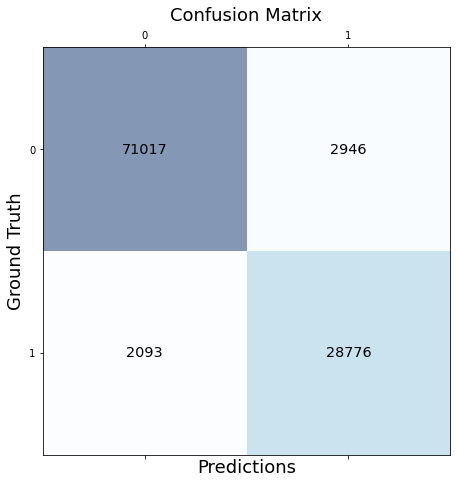

0.951932615995116
0.9194932178747744


In [ ]:
conf_matrix = confusion_matrix(y_valid, pred_valid_rf_patch)
plot_confusion_matrix(conf_matrix)
print(accuracy_score(y_valid, pred_valid_rf_patch))
print(f1_score(y_valid, pred_valid_rf_patch))

## KNN
Here the size of our matrix X is really important (314496, 65), using directly on it the KNN will be very long to do any prediction. To save some calculation power it is important to reduce the number of features of our input. To do so, we use the PCA algorithm and consider the new number of features as a new hyperparameter.

Search for the best parameters

In [39]:
reduction_values = [5,10,15] 
k_values = np.arange(1,42,4)
for r in tqdm_notebook(reduction_values):
  accuracies = np.zeros(k_values.shape)
  pca_instance = PCA(r, random_state = 10)
  X_train_reduced = pca_instance.fit_transform(X_train)
  X_valid_reduced = pca_instance.fit_transform(X_valid)
  for ind,k in tqdm_notebook(enumerate(k_values)):
      classifier = KNeighborsClassifier(n_neighbors=k)
      classifier.fit(X_train_reduced, y_train)
      prediction = classifier.predict(X_valid_reduced)
      accuracies[ind] = accuracy_score(y_valid, prediction)
  #plt.plot(k_values,accuracies) 
  #plt.figure()
  print("Best accuracy of %f with reduction to %d features and K=%d" % (accuracies.max(),r,np.argmax(accuracies)))   

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Best accuracy of 0.908797 with reduction to 5 features and K=9


0it [00:00, ?it/s]

Best accuracy of 0.909112 with reduction to 10 features and K=9


0it [00:00, ?it/s]

Best accuracy of 0.909112 with reduction to 15 features and K=9


We obtain here the same accuracy for both 10 and 15 features (with 9 neighbors), to optimise the speed of our algorithm we will take 10 features for the following study.

Train the KNN with the best hyperparameters

In [40]:
pca_instance = PCA(10, random_state = 10)
X_train_reduced = pca_instance.fit_transform(X_train)
X_valid_reduced = pca_instance.fit_transform(X_valid)
X_test_reduced = pca_instance.fit_transform(X_test)

In [41]:
classifier = KNeighborsClassifier(n_neighbors=9)
classifier.fit(X_train_reduced, y_train)

KNeighborsClassifier(n_neighbors=9)

In [42]:
pred_valid_knn_patch = classifier.predict(X_valid_reduced)
pred_test_knn_patch = classifier.predict(X_test_reduced)

Plot the confusion matrix of our model 

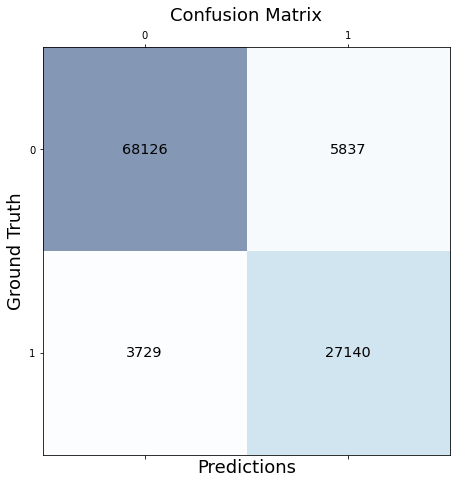

0.9087492368742369
0.8501707233029476


In [43]:
conf_matrix = confusion_matrix(y_valid, pred_valid_knn_patch)
plot_confusion_matrix(conf_matrix)
print(accuracy_score(y_valid, pred_valid_knn_patch))
print(f1_score(y_valid, pred_valid_knn_patch))

# Then

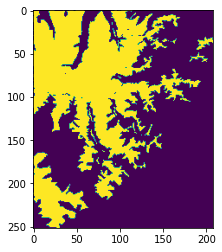

In [ ]:
#lets try to see the image 
#image = np.array((y_flatten[2:3]))
#plt.imshow(np.resize(image,(252,208)))

### Visualize snow in predicted years

In [ ]:
#Same as clément did above essentially
index_2017 = int((len(prediction)/3))
index_2019 = int((len(prediction)/3)*2)
index_2021 = int((len(prediction)/3)*3)

pred_2017 = prediction[0:index_2017]
pred_2019 = prediction[index_2017:index_2019]
pred_2021 = prediction[index_2019:index_2021]

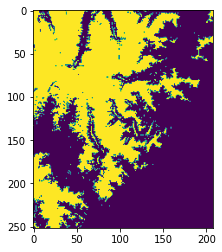

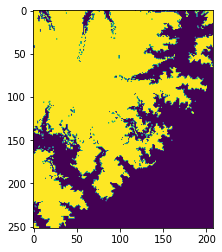

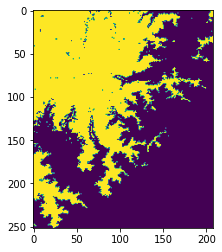

In [ ]:
plt.imshow(np.resize(pred_2017,(252,208)))
plt.figure()
plt.imshow(np.resize(pred_2019,(252,208)))
plt.figure()
plt.imshow(np.resize(pred_2021,(252,208)))

In [ ]:
snow = []
years = [pred_2017,pred_2019,pred_2021]
for year in years:
  snow.append(year.sum())

In [ ]:
snow_years = ["December_2017","December_2019","December_2021"]

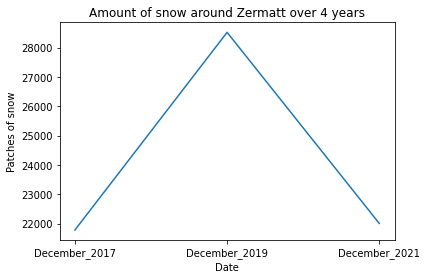

In [ ]:
plt.plot(snow_years,snow)
plt.xlabel('Date')
plt.ylabel('Patches of snow')
plt.title('Amount of snow around Zermatt over 4 years')
plt.show()

## Hyperparameter search for random forest parameters

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

TypeError: ignored

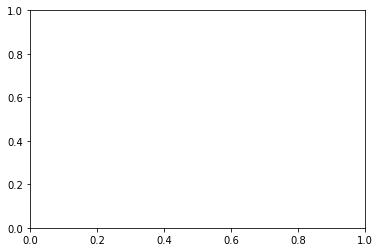

In [ ]:
#random_states = np.linspace(10,100,10)
criterions = ['gini', 'entropy']
amount_estimators = np.linspace(50,150,5)
combinations = []
accuracies = []
for criterion in tqdm_notebook(criterions):
  for amountestimator in tqdm_notebook(amount_estimators):
    classifier = RandomForestClassifier(random_state = 10, n_estimators=int(amountestimator), criterion=criterion, max_samples = 100000)
    classifier.fit(X_train, y_train)
    prediction = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, prediction)
    combinations.append((criterion,amountestimator))
    accuracies.append(accuracy)

plt.plot(combinations,accuracies)